Librerías necesarias:

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import csv
from PIL import Image
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix
#from scipy import stats
#KERAS
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from sklearn.metrics import classification_report, cohen_kappa_score
import collections
from keras.models import model_from_json
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json

Leemos el directorio y contamos cuántas imágenes hay

In [2]:
# APTOS 2019
directoris = []
contador = []
fitxers = []
path_img = []

#Devuelve el path a las imágenes (path_img), el nombre de las imágenes (fitxers) y la cantidad (contador)
for dirname, _, filenames in os.walk('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train_images',followlinks=False):
    directoris.append(os.path.join(dirname))
    for i in filenames:
        if not '._' in i:
            fitxers.append(i)
            path_img.append(dirname+"/"+i)
    contador.append(dirname+': CONTÉ '+str(len(fitxers)) + ' FOTOS')

In [3]:
# APTOS 2015
directoris2 = []
contador2 = []
fitxers2 = []
path_img2 = []

#Devuelve el path a las imágenes (path_img), el nombre de las imágenes (fitxers) y la cantidad (contador)
for dirname2, _, filenames2 in os.walk('/Volumes/Lorena/APTOS/archive/rescaled_train_896/rescaled_train_896',followlinks=False):
    directoris2.append(os.path.join(dirname2))
    for i in filenames2:
        if not '._' in i:
            fitxers2.append(i)
            path_img2.append(dirname2+"/"+i)
    contador2.append(dirname2+': CONTÉ '+str(len(fitxers2)) + ' FOTOS')

In [4]:
# Cargamos el train.csv de APTOS2019
csv_train = open('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train.csv')
csvreader = csv.reader(csv_train)
rows = []
for row in csvreader:
        rows.append(row)

In [5]:
# Cargamos el train.csv de APTOS2015
csv_train2 = open('/Volumes/Lorena/APTOS/archive/trainLabels.csv')
csvreader2 = csv.reader(csv_train2)
rows2 = []
for row in csvreader2:
        rows2.append(row)

Creamos los sets de imágenes y etiquetas

In [6]:
path_img_all = path_img + path_img2
rows_all = rows + rows2
print(f'Total of images: {len(path_img_all)}')
print(f'Total of rows: {len(rows_all)}')

Total of images: 38788
Total of rows: 38790


In [7]:
data = []
labels = []
nombres_imgs = []
items = []
# recorremos los paths de las imágenes y de las filas del csv, buscamos el nombre de la imágen en el
#csv y creamos dos sets de datos con las imágenes y la etiqueta correspondiente en la misma posición
for imagePath in path_img_all:
    #print(imagePath)
    if not '._' in imagePath:
        for row in rows_all:
            item = imagePath.split(os.path.sep)[-1]
            if item[0:item.find('.')] == row[0][0:row[0].find(';')] and item[1]!='_' :
                # leemos la imagen
                items.append(item)
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
                # creamos los arrays de imágenes y etiquetas
                nombres_imgs.append(imagePath)
                data.append(image)
                labels.append(row[0][(row[0].find(';'))+1:])

Procesamos las imágenes recortando los bordes y aplicando filtro gausiano

In [8]:
#Función que recorta los bordes de las imágenes 
def crop_border(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img > 7       
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        img = np.stack([img1,img2,img3],axis=-1)
    return img

In [9]:
processed_data = []
for img in data:
    image = img
    # Cortamos los bordes
    image = crop_border(image)
    image = cv2.resize(image, (256, 256))
    # Aplicamos GaussianBlur
    blurred = cv2.blur(image, ksize=(int(256 / 6), int(256 / 6)))
    image_blur = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    processed_data.append(image_blur)

In [10]:
labels[0:10]

['2', '4', '1', '0', '0', '4', '0', '2', '2', '1']

Balanceamos los datos

In [12]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'0': 27606, '1': 2812, '2': 6287, '3': 1066, '4': 1003}

In [13]:
minimo=min(counts)
print("Minimo support: ", minimo) #cogemos el minimo para equiparar la data de cada label

Minimo support:  1003


In [14]:
lab_0=0; lab_1=0; lab_2=0; lab_3=0; lab_4=0
ind_0=[]; ind_1=[]; ind_2=[]; ind_3=[]; ind_4=[]

for a in range(len(labels)): #hacemos cinco listas de los indices de cada label de longitud=minimo
    if (labels[a]=='0' and lab_0<minimo):
        lab_0+=1
        ind_0.append(a)
    if (labels[a]=='1' and lab_1<minimo):
        lab_1+=1
        ind_1.append(a)
    if (labels[a]=='2' and lab_2<minimo):
        lab_2+=1
        ind_2.append(a)
    if (labels[a]=='3' and lab_3<minimo):
        lab_3+=1
        ind_3.append(a)
    if (labels[a]=='4' and lab_4<minimo):
        lab_4+=1
        ind_4.append(a)

Creamos los conjuntos de entrenamiento, validación y prueba

In [15]:
data_arr = np.array(processed_data)
labels_arr = np.array(labels)

final = int(minimo*0.8)

#se separa la data en train y test
ind_Train = ind_0[:final] + ind_1[:final] + ind_2[:final] + ind_3[:final] + ind_4[:final] 
ind_Test =  ind_0[final:] + ind_1[final:] + ind_2[final:] + ind_3[final:] + ind_4[final:]

print("Lista train:", len(ind_Train)," test: ", len(ind_Test),"\nTotal lista: ", len(ind_Train)+len(ind_Test), " minimo total:", minimo*5)

Train = ind_Train + ind_Test

Train_Data = data_arr[Train, :, :, :] #Todos los datos (train + test)
Train_Labels = to_categorical(np.array(labels_arr[Train])) #Todos las etiquetas (train + test)

indTrainP = np.random.permutation(ind_Train)
indTestP = np.random.permutation(ind_Test) 
 
       
train_data = data_arr[indTrainP, :, :, :] #Datos con el 80% de los datos (train)
print(type(train_data))
print(np.shape(train_data))
train_labels = to_categorical(np.array(labels_arr[indTrainP])) 
print(type(train_labels))
print(np.shape(train_labels))
test_data = data_arr[indTestP, :, :, :] #Datos con el 20% de los datos (test)
test_labels = to_categorical(np.array(labels_arr[indTestP])) #etiquetas de test codificadas (x,4)
print("Shape of labels", train_labels.shape, "shape of data train", train_data.shape, "shape of test train", test_data.shape)

Lista train: 4010  test:  1005 
Total lista:  5015  minimo total: 5015
<class 'numpy.ndarray'>
(4010, 256, 256, 3)
<class 'numpy.ndarray'>
(4010, 5)
Shape of labels (4010, 5) shape of data train (4010, 256, 256, 3) shape of test train (1005, 256, 256, 3)


In [16]:
#Para comprobar que el número es el mismo
counterT=collections.Counter(np.argmax(test_labels,axis=1))
print("counter test", counterT)

counterTR=collections.Counter(np.argmax(train_labels,axis=1))
print("counter train", counterTR)

counter test Counter({4: 201, 0: 201, 3: 201, 1: 201, 2: 201})
counter train Counter({3: 802, 1: 802, 0: 802, 2: 802, 4: 802})


Creamos el modelo y entrenamos

In [17]:
# Modelo en red preentrenada
base_model = VGG16(input_shape = (256, 256, 3), # El tamaño de nuestras imágenes
include_top = False, # Quitamos la última capa totalmente conectada
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Aplanamos la capa de salida del modelo a una sola dimension
x = layers.Flatten()(base_model.output)

# Añadimos una capa totalmente conectada con 1024 neuronas y una activación ReLU
x = layers.Dense(1024, activation='relu')(x)

# Añadimos una dropout de 0.5
x = layers.Dropout(0.5)(x)

# Añadimos una capa densa con una activación softmax para que de un vector de probabilidades en la salida por cada clase
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

2022-05-30 15:33:45.647062: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Creamos una clase QWK callback correspondiente al cálculo del Quadratic Wieghted Kappa
class QWKCallback(Callback):
    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('VGG16_bestqwk_adamax.h5')

# Definimos el criterio de early stopping
pat = 5 # Este es el número de épocas sin mejora después de las cuales el entrenamiento parará
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Definimos el checkpoint callback del modelo 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Final_VGG16_qwk_adamax.h5', verbose=1, save_best_only=True)

In [19]:
history = []
score = []
score_history = []
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE):
    model.compile(optimizer="Adamax", loss = 'categorical_crossentropy', metrics = ['accuracy']) 
    vgg = model.fit(t_x, t_y, epochs = EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint, 
              QWKCallback((val_x,val_y))], validation_split=0.1, verbose = 1) 
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    score.append(model.evaluate(val_x, val_y)[1])
    return vgg, score

epochs=10
batch_size=100

accuracy = []
history_loss = []
history_val_loss = []

t_x, val_x, t_y, val_y = train_test_split(train_data, train_labels, test_size=0.1, random_state = np.random.randint(1,1000, 1)[0])

model_history, score_hist = fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size)
print("======="*12, end="\n\n\n")
history.append(model_history)
score_history.append(score_hist)

2022-05-30 15:34:43.472988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
33/33 [==============================] - 627s 19s/step - loss: 61.3631 - accuracy: 0.4440 - val_loss: 10.7328 - val_accuracy: 0.6150

Epoch 00001: val_loss improved from inf to 10.73283, saving model to Final_VGG16_qwk_adamax.h5
Epoch 0 : QWK: 0.6284831927782397
saving checkpoint:  0.6284831927782397
Epoch 2/10
33/33 [==============================] - 620s 19s/step - loss: 5.5865 - accuracy: 0.6302 - val_loss: 1.5574 - val_accuracy: 0.6482

Epoch 00002: val_loss improved from 10.73283 to 1.55739, saving model to Final_VGG16_qwk_adamax.h5
Epoch 1 : QWK: 0.7567778759793241
saving checkpoint:  0.7567778759793241
Epoch 3/10
33/33 [==============================] - 608s 18s/step - loss: 1.0006 - accuracy: 0.6946 - val_loss: 1.0507 - val_accuracy: 0.6510

Epoch 00003: val_loss improved from 1.55739 to 1.05072, saving model to Final_VGG16_qwk_adamax.h5
Epoch 2 : QWK: 0.739088069876979
Epoch 4/10
33/33 [==============================] - 652s 20s/step - loss: 0.7043 - accuracy: 0.742

In [22]:
def acc_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train_acc', 'Val_acc'], loc='upper left')
    plt.show()
    
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train_loss', 'Val_loss'], loc='upper left') 
    plt.show()


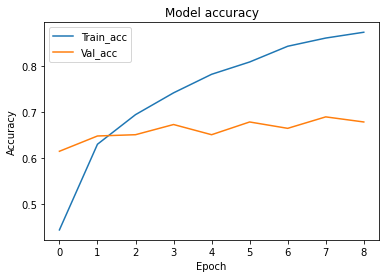

In [23]:
acc_plot(model_history)

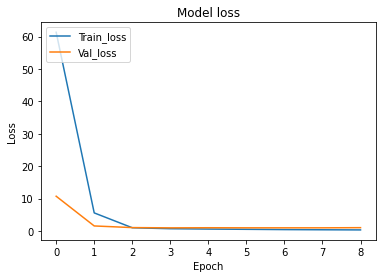

In [24]:
loss_plot(model_history)

Evaluamos el modelo con los datos de test

In [20]:
# Evaluacion basica de la accuracy
v = model.evaluate(test_data, test_labels)
w = model.metrics_names

for t in range (len(w)):
    print("\n", w[t],":", np.round(v[t]*100,2))

32/32 [==============================] - 159s 5s/step - loss: 0.8950 - accuracy: 0.7174

 loss : 89.5

 accuracy : 71.74


Hacemos la predicción de los datos de test y calculamos la precisión, el recall, el f1-score y el support

In [21]:
# Obtencion de la precison, recall, f1-score y support por cada clase
test_pred = model.predict(test_data)
test_pred_de = np.argmax(test_pred,axis=1)
test_labels_de = np.argmax(test_labels, axis=1)
print('VGG16 MODEL')
print(classification_report(test_labels_de, test_pred_de))

VGG16 MODEL
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       201
           1       0.65      0.58      0.62       201
           2       0.97      0.74      0.84       201
           3       0.51      0.66      0.57       201
           4       0.66      0.66      0.66       201

    accuracy                           0.72      1005
   macro avg       0.74      0.72      0.72      1005
weighted avg       0.74      0.72      0.72      1005



Calculamos las curvas ROC y la matriz de confusión

/var/folders/8t/60tzsb9x2p1_hm55m00nhbgh0000gn/T/ipykernel_30321/3526741685.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


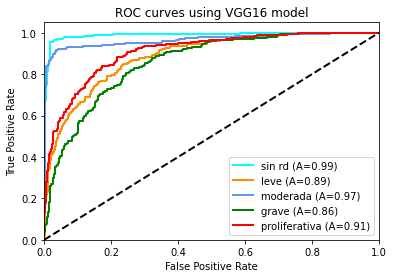

In [25]:
# Calculo de las curvas roc por clase
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=[0,1,2,3,4]

for i in n_classes:
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculamos el micro-average de la curva ROC y el área ROC
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Agregamos primero todos los falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in n_classes]))

# Ahora interpolamos todas la curvas roc en estos puntos
mean_tpr = np.zeros_like(all_fpr)
for i in n_classes:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finalmente hacemos la media y calculamos AUC
mean_tpr /= len(n_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','red'])
d={0:"sin rd", 1:"leve", 2:"moderada", 3: "grave", 4:"proliferativa"}
for i, color in zip(n_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (A={1:0.2f})'
             ''.format(d[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC curves using VGG16 model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

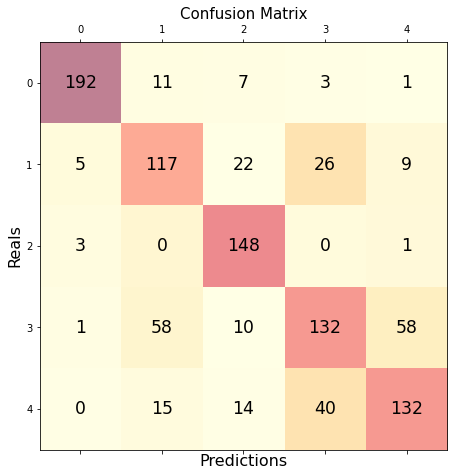

In [26]:
# Calculamos la matriz de confusión
mat_con = (confusion_matrix(test_labels_de, test_pred_de, labels=[0, 1,2,3,4]))
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Reals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [29]:
#Funcion para guardar el modelo

def save_model(model, name):
    model_json = model.to_json()
    with open('{}.json'.format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights('{}.h5'.format(name)) #serialize weights to HDF5
    print("Saved model to disk")
    

In [30]:
name="entrenamiento_2015-2019_QWK_Adamax" #nombre del modelo
save_model(model,name)

learning_rate = open("lr_entrenamiento_2015-2019_QWK_Adamax.txt", "w+")
learning_rate.write(str(K.eval(model.optimizer.lr)))
learning_rate.close()

Saved model to disk


Mostramos las predicciones de 10 imágenes a modo de ejemplo

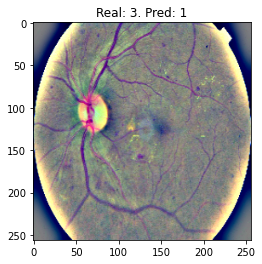

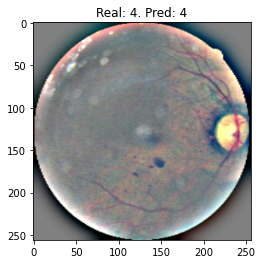

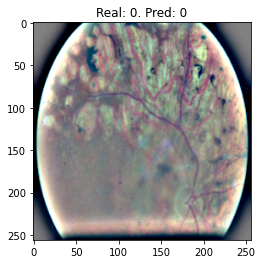

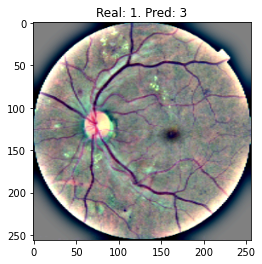

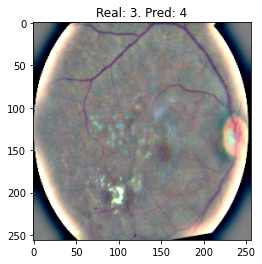

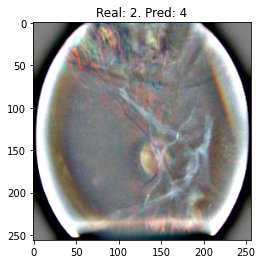

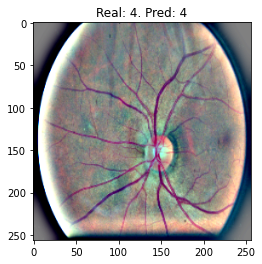

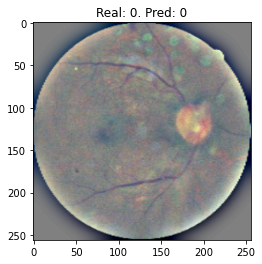

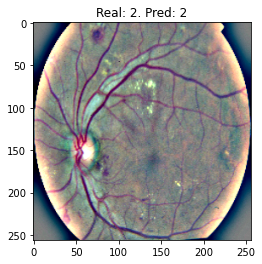

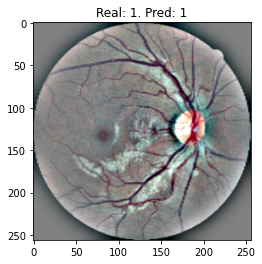

In [31]:
cont = 0
for i in test_data[10:20]:
    plt.figure()
    im = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    etiq_real = test_labels_de[cont]
    etiq_pred = np.argmax(test_pred[cont])
    plt.title(f'Real: {etiq_real}. Pred: {etiq_pred}')
    cont = cont+1